
Forward Backward pass

Step1: Import libraries

In [1]:
#Importing libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
np.random.seed(1)

Step2: Define padding

In [2]:
#Padding across all sides for convolution
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    return X_pad

Step 3: Generate a random image and pad it

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


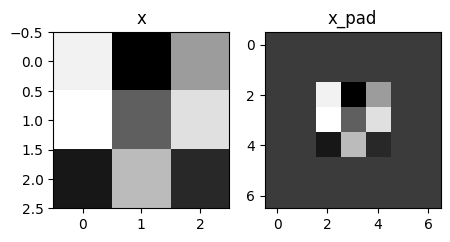

In [3]:
#Random number
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2) #N,H,W,C
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

Step4: Define convoltuion Y = WX+b. Followed by Pooling

In [4]:
#Convolution is defined on sliced image whose size is equal to the mask size
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev,W)
    Z = np.sum(s)
    Z = Z + b.astype(float)
    return Z

$$n_H = ⌊\frac{n_{hprev}-f +2 \times pad}{stride}⌋+1 $$ \\
$$n_W = ⌊\frac{n_{wprev}-f +2 \times pad}{stride}⌋+1 $$ \\
$$n_C = number of filters$$

In [5]:
#Forward pass
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride']
    pad = hparameters['pad']

    n_H = int((n_H_prev + 2*pad - f)/stride) + 1 #Calculate size of resultant image
    n_W =int((n_W_prev + 2*pad - f)/stride) + 1

    Z = np.zeros([m, n_H, n_W, n_C])
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride
                    horiz_end = w*stride + f

                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:,:,:,c])

    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [6]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])


Z's mean = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


<ipython-input-5-896292926059>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:,:,:,c])


Step5: Backward pass

$$dA+= \sum_{h=0}^{n_H}\sum_{w=0}^{n_W}W_c \times dZ_{hw}$$ \\
$$dW_c += \sum_{h=0}^{n_H}\sum_{w=0}^{n_W} a_{slice} \times dZ_{hw}$$ \\
$$db = \sum_h \sum_w dZ_{hw}$$

In [7]:
#
def conv_backward(dZ, cache):

    (A_prev, W, b, hparameters) = cache

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    (m, n_H, n_W, n_C) = dZ.shape

    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)

    for i in range(m):

        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):

                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]


        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    return dA_prev, dW, db

In [8]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 0.6347704472654743
dW_mean = 1.5572657428497354
db_mean = 7.839232564616838
